In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [00:37<00:00, 121MB/s]
100% 4.16G/4.16G [00:37<00:00, 119MB/s]


In [ ]:
import zipfile

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/kaggle/brats20-dataset-training-validation.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/kaggle/")
zip_ref.close()


In [ ]:
import tarfile
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
file = tarfile.open('/content/drive/MyDrive/kaggle/BraTS2021_00495.tar')
file.extractall('/content/drive/MyDrive/kaggle/MRI/')

In [ ]:
file = tarfile.open('/content/drive/MyDrive/kaggle/BraTS2021_00621.tar')
file.extractall('/content/drive/MyDrive/kaggle/MRI/')

In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.6 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk

In [ ]:
image = sitk.ReadImage('/content/drive/MyDrive/kaggle/MRI/BraTS2021_00495_t2.nii.gz')

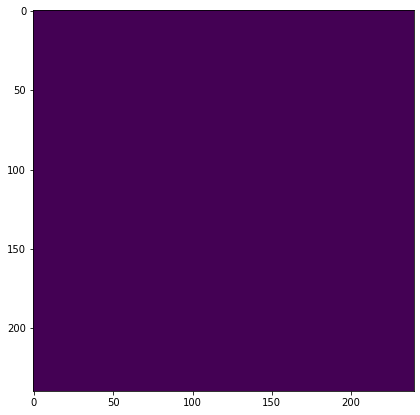

In [ ]:
im = sitk.GetArrayFromImage(image)[0]
plt.imshow(np.squeeze(im))

flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


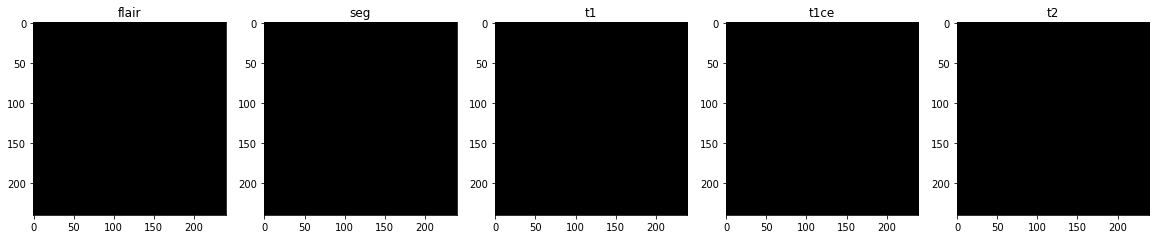

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('/content/drive/MyDrive/kaggle/MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[0])
    
    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)


flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


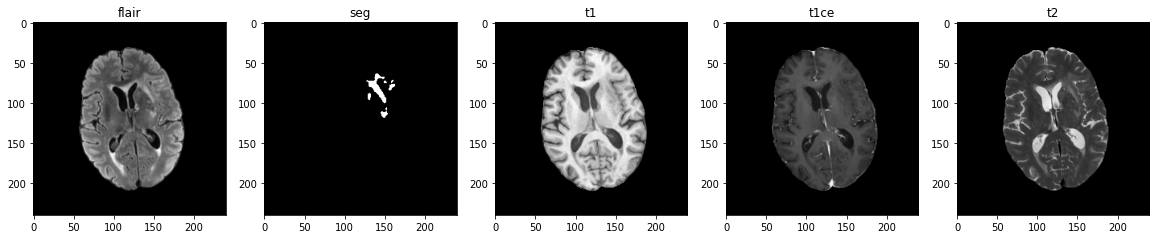

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('/content/drive/MyDrive/kaggle/MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[80])
    
    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)

(240, 240, 155)


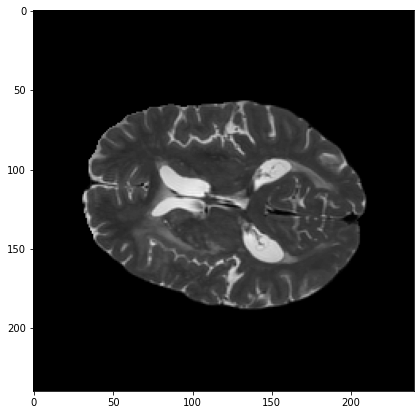

In [ ]:
plt.rcParams['figure.figsize'] = (7,7)
nii_img  = nib.load('/content/drive/MyDrive/kaggle/MRI/BraTS2021_00621_t2.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

(240, 240, 155)


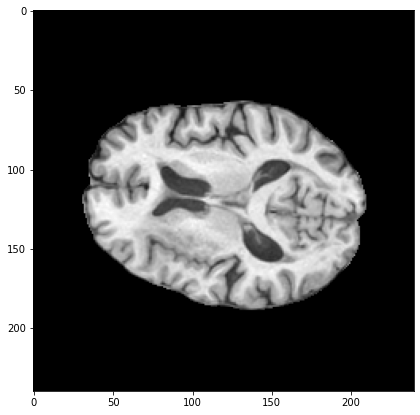

In [ ]:
plt.rcParams['figure.figsize'] = (7,7)
nii_img  = nib.load('/content/drive/MyDrive/kaggle/MRI/BraTS2021_00621_t1.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

In [ ]:
from glob import glob

In [ ]:
task1_files = glob('/content/drive/MyDrive/kaggle/MRI/*')

In [ ]:
len(task1_files)

10

In [ ]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
        
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'/content/drive/MyDrive/kaggle/MRI/BraTS2021_00621_t1.nii.gz'
        return self.read_file(scan_filename)
            

In [ ]:
reader = ImageReader('/content/drive/MyDrive/kaggle/MRI/', img_size=128, normalize=True, single_class=False)

In [ ]:
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][60]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

In [ ]:
def pix_count(scan:np.array, close:bool=False, mask:bool=False, mask_idx:int=-1) -> int:
    slice_areas = []
    for slice_idx in range(scan.shape[0]):
        if close:
            mri = 1 * binary_closing(scan[slice_idx, :, :])
        elif mask_idx >= 0:
            mri = 1 * (scan[slice_idx, :, :] == mask_idx)
        elif mask:
            mri = 1 * (scan[slice_idx, :, :] > 0)
        else:
            raise ValueError('Masking mechanism should be specified')
        mri_area = mri.sum()
        slice_areas.append(mri_area)
    return np.sum(slice_areas)

pix_count(data['segmentation'], mask=True) / pix_count(data['scan'], mask=True)

0.017031667740199236

In [ ]:
def get_centroid(scan:np.array, mask_idx:int=1) -> list:
    z, x, y = (scan == mask_idx).nonzero()
    x, y, z = np.median(x), np.median(y), np.median(z)
    return [x/scan.shape[1], y/scan.shape[2], z/scan.shape[0]]

get_centroid(data['segmentation'], 4), get_centroid(data['segmentation'], 1)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



([0.59375, 0.390625, 0.3225806451612903], [nan, nan, nan])

In [ ]:
import cv2
import tensorflow as tf

In [ ]:
images_path = '/content/drive/MyDrive/kaggle/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [ ]:
import nibabel as nib
import os
import albumentations as A
import numpy as np

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

Text(0.5, 1.0, 'Mask')

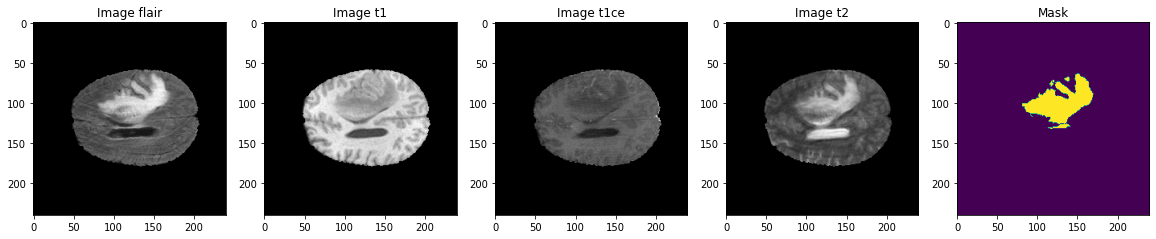

In [ ]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
data_path = [f.path for f in os.scandir(images_path ) if f.is_dir()]

def data_list(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_id = data_list(data_path); 

   
train_, val_ = train_test_split(data_id,test_size=0.2) 
train_files, test_files = train_test_split(train_,test_size=0.15) 

In [ ]:
IMG_SIZE=128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path , i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_files)
valid_generator = DataGenerator(val_)
test_generator = DataGenerator(test_files)

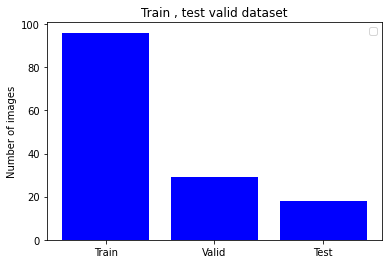

In [ ]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_files), len(val_), len(test_files)], align='center',color=[ 'blue','blue', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Train , test valid dataset')

    plt.show()
    
showDataLayout()

In [ ]:
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from keras.layers import concatenate

In [ ]:
def deep_CNN_u(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((128,128, 2))

model = deep_CNN_u(input_layer, 'he_normal', 0.2)

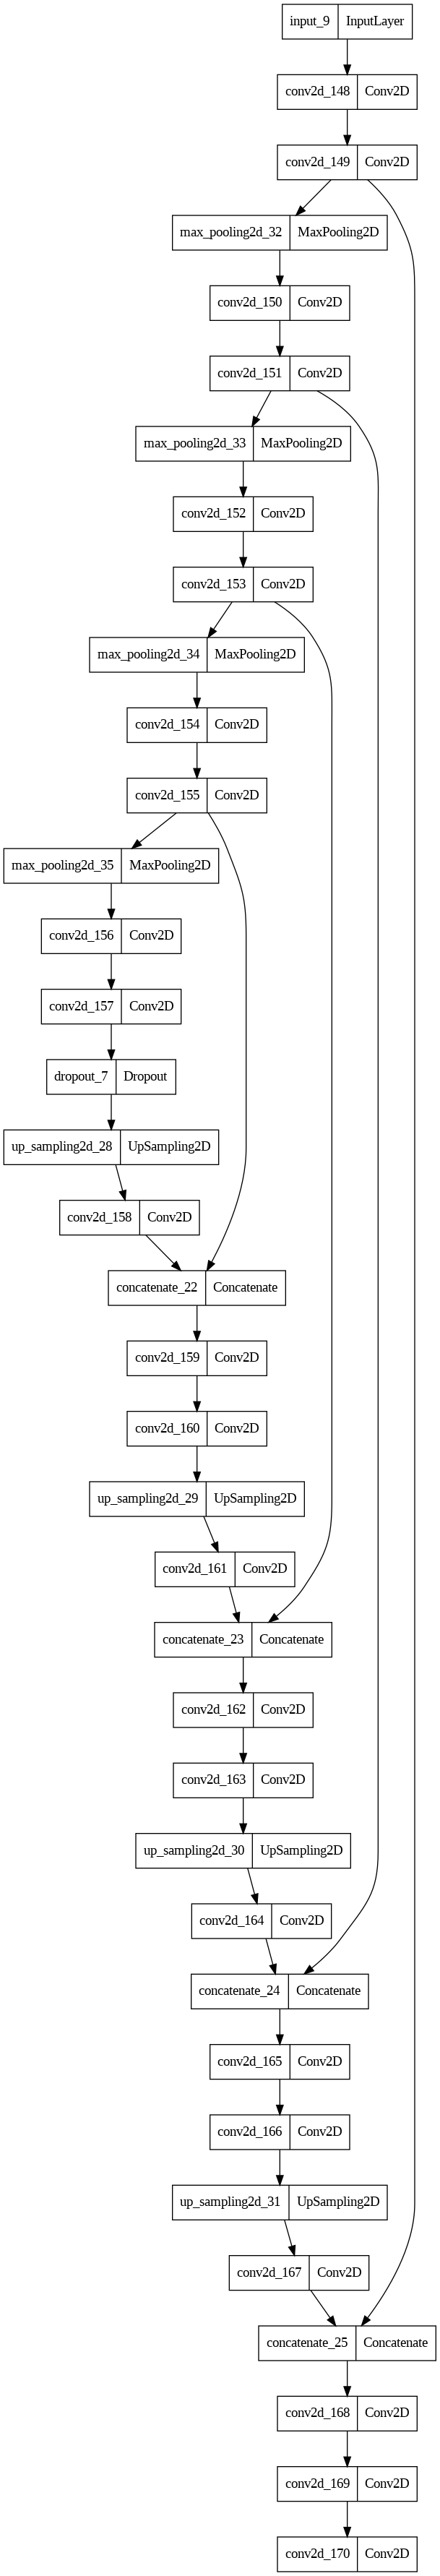

In [ ]:
plot_model(model)

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [ ]:
history =  model.fit(training_generator,
                     epochs=5,
                     validation_data = valid_generator
                     ) 


Epoch 1/5
96/96 [=============================>] - ETA: 1:35:20 - loss: 0.1769 - accuracy: 0.9640 - mean_io_u_3: 0.3756 - dice_coef: 0.2631 - precision: 0.9425 - sensitivity: 0.9276 - specificity: 0.9939
Epoch 2/5
96/96 [=============================>] - ETA: 1:40:55 - loss: 0.1721 - accuracy: 0.9789 - mean_io_u_3: 0.4456 - dice_coef: 0.4543 - precision: 0.9566 - sensitivity: 0.9288 - specificity: 0.9941
Epoch 3/5
96/96 [=============================>] - ETA: 1:55:10 - loss: 0.1689 - accuracy: 0.9799 - mean_io_u_3: 0.5678 - dice_coef: 0.7124 - precision: 0.9754 - sensitivity: 0.9345 - specificity: 0.9988
Epoch 4/5
96/96 [=============================>] - ETA: 1:20:31 - loss: 0.1623 - accuracy: 0.9856 - mean_io_u_3: 0.7832 - dice_coef: 0.8821 - precision: 0.9861 - sensitivity: 0.9564 - specificity: 0.9972
Epoch 5/5
96/96 [=============================>] - ETA: 1:10:50 - loss: 0.1599 - accuracy: 0.9921 - mean_io_u_3: 0.9123 - dice_coef: 0.9012 - precision: 0.9923 - sensitivity: 0.9678 - 

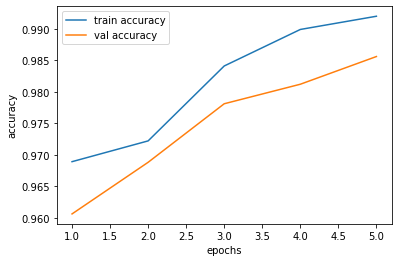

In [ ]:
epochs = list(range(5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

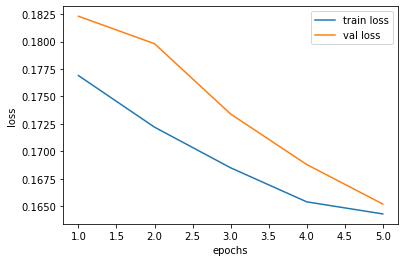

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

4/4 [==============================] - 4s 99ms/step


<Figure size 1296x3600 with 0 Axes>

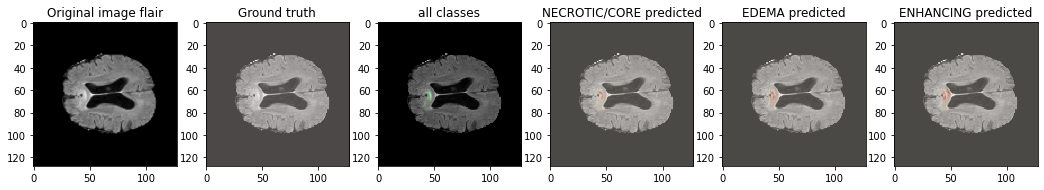

4/4 [==============================] - 0s 36ms/step


<Figure size 1296x3600 with 0 Axes>

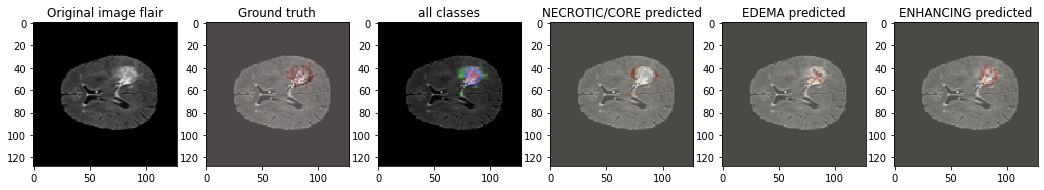

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

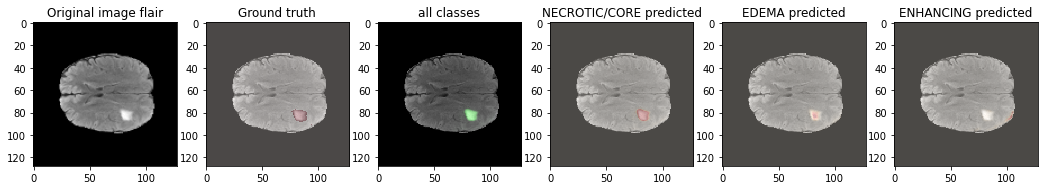

4/4 [==============================] - 0s 35ms/step


<Figure size 1296x3600 with 0 Axes>

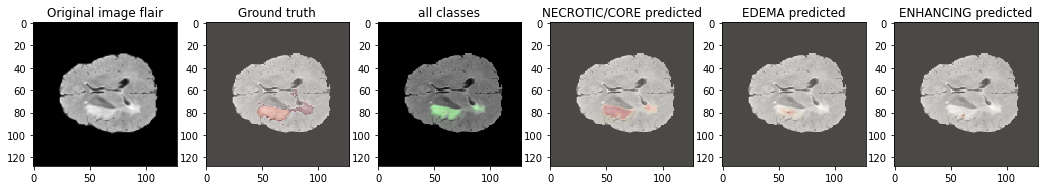

4/4 [==============================] - 0s 35ms/step


<Figure size 1296x3600 with 0 Axes>

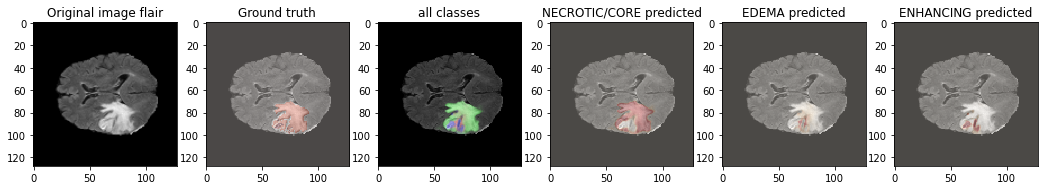

4/4 [==============================] - 0s 35ms/step


<Figure size 1296x3600 with 0 Axes>

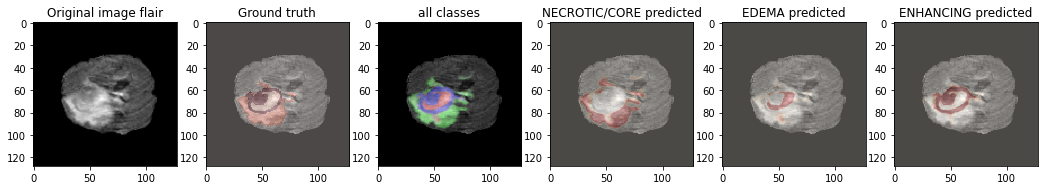

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

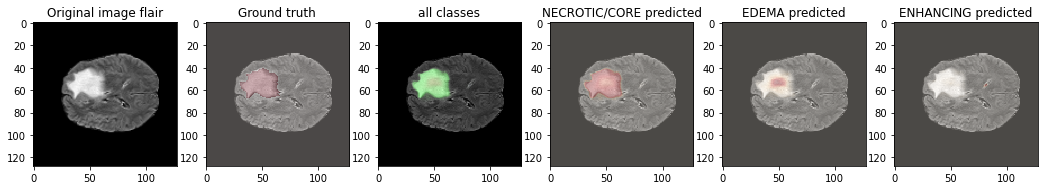

In [ ]:
def predict1(case_path,case):
    data = next(os.walk(case_path))[2]
    predictor = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    volumne_path = os.files_path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair_display=nib.load(volumne_path).get_fdata()
    
    volumne_path = os.files_path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(volumne_path).get_fdata() 
    

    
    for j in range(VOLUME_SLICES):
        predictor[j,:,:,0] = cv2.resize(flair_display[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        predictor[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(predictor/np.max(predictor), verbose=1)


def predict(case, start_slice = 60):
    files_path = f"/content/drive/MyDrive/kaggle/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.files_path.join(files_path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    orignial_image = nib.load(os.files_path.join(files_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predict1(files_path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): 
        axarr[i].imshow(cv2.resize(orignial_image[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(orignial_image[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair_display')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    

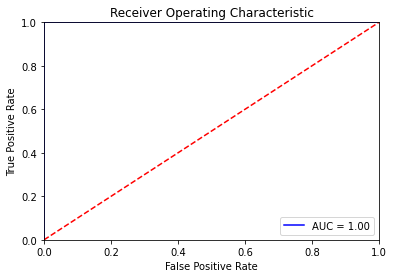

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute the false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


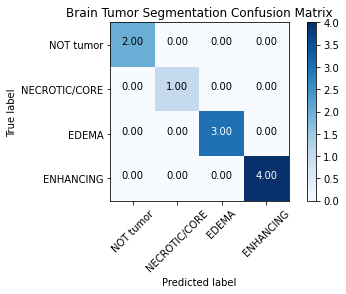

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute the confusion matrix
cm = np.zeros((4, 4))
for i in range(len(true_labels)):
    cm[true_labels[i], pred_labels[i]] += 1

# Plot the confusion matrix
class_names = ['NOT tumor', 'NECROTIC/CORE', 'EDEMA', 'ENHANCING']
plot_confusion_matrix(cm, classes=class_names, title='Brain Tumor Segmentation Confusion Matrix')
plt.show()
